<a href="https://colab.research.google.com/github/IlyaZelinskiy/Wav2vec_CFT_SHIFT_LAB/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_TF_IDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 4.2 MB/s 
     |████████████████████████████████| 182 kB 45.6 MB/s 
     |████████████████████████████████| 212 kB 49.0 MB/s 
     |████████████████████████████████| 115 kB 55.2 MB/s 
     |████████████████████████████████| 127 kB 54.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [5]:
import torch
from datasets import load_dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from torch.utils.data import Dataset, DataLoader
import pandas as pd

In [4]:
dataset = load_dataset("hf-internal-testing/librispeech_asr_demo",'clean', split="validation")
dataset = dataset.sort("id")
sampling_rate = dataset.features["audio"].sampling_rate

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset librispeech_asr_demo downloaded and prepared to /root/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_demo/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b. Subsequent calls will reuse this data.


In [9]:
corpus = dataset['text']

In [10]:
corpus[0]

'MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL'

In [11]:
# создадим сперва три токена
l_A = corpus[0].lower().split()
l_B = corpus[1].lower().split()
l_C = corpus[2].lower().split()

In [19]:
# считаем bag of words
word_set = set(l_A).union(set(l_B)).union(set(l_C))

word_dict_A = dict.fromkeys(word_set, 0)
word_dict_B = dict.fromkeys(word_set, 0)
word_dict_C = dict.fromkeys(word_set, 0)

for word in l_A:
    word_dict_A[word] += 1

for word in l_B:
    word_dict_B[word] += 1

for word in l_C:
    word_dict_C[word] += 1

In [20]:
def compute_tf(word_dict, l):
    tf = {}
    sum_nk = len(l)
    for word, count in word_dict.items():
        tf[word] = count/sum_nk
    return tf
    
tf_A = compute_tf(word_dict_A, l_A)
tf_B = compute_tf(word_dict_B, l_B)
tf_C = compute_tf(word_dict_C, l_C)

In [23]:
import math
#IDF - измеряет непосредственную важность данного термина для текущего текста
def compute_idf(strings_list):
    n = len(strings_list)
    idf = dict.fromkeys(strings_list[0].keys(), 0)
    for l in strings_list:
        for word, count in l.items():
            if count > 0:
                idf[word] += 1
    
    for word, v in idf.items():
        idf[word] = math.log(n / float(v))
    return idf
    
idf = compute_idf([word_dict_A, word_dict_B, word_dict_C])

In [25]:
#tf-idf
def compute_tf_idf(tf, idf):
    tf_idf = dict.fromkeys(tf.keys(), 0)
    for word, v in tf.items():
        tf_idf[word] = v * idf[word]
    return tf_idf
    
tf_idf_A = compute_tf_idf(tf_A, idf)
tf_idf_B = compute_tf_idf(tf_B, idf)
tf_idf_C = compute_tf_idf(tf_C, idf)

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import re
import string
# Preprocessing and tokenizing
def preprocessing(line):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    return line


In [99]:
#После отчистки, текста надо прогнать наш текст через TfidfVectorizer и кластеризовать при помощи K-средних.
all_text =corpus
tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocessing)
tfidf = tfidf_vectorizer.fit_transform(all_text)

kmeans = KMeans(n_clusters=2).fit(tfidf)
kmean_indices = kmeans.fit_predict(tfidf)


In [156]:
len(scatter_plot_points)

532

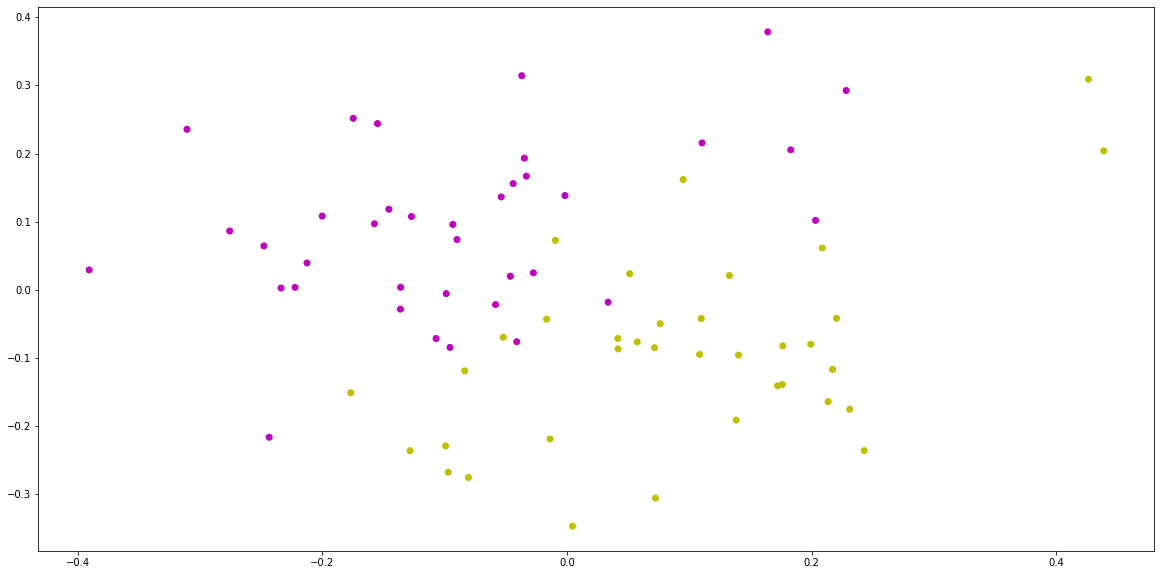

In [105]:
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(tfidf.toarray())
colors = ["y", "m" ]

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]
fig, ax = plt.subplots(figsize=(20,10))

ax.scatter(x_axis, y_axis, c=[colors[d] for d in kmean_indices])

In [76]:
all_text[1] #МАНЕРЫ #МИСТЕРА КВИЛТЕРА НЕ МЕНЕЕ ИНТЕРЕСНЫ, ЧЕМ ЕГО СУТЬ

"NOR IS MISTER QUILTER'S MANNER LESS INTERESTING THAN HIS MATTER"

In [77]:
all_text[6] #ОБ ОБЩИХ ПРИНЦИПАХ #ИСКУССТВА #МИСТЕР КВИЛТЕР ПИШЕТ С ТАКОЙ ЖЕ ЯСНОСТЬЮ

'ON THE GENERAL PRINCIPLES OF ART MISTER QUILTER WRITES WITH EQUAL LUCIDITY'

In [78]:
all_text[9] #ОН ОСОБЕННО ГОРЬКО СЕТУЕТ НА РАЗРЫВ, КОТОРЫЙ ПРОИЗОШЕЛ МЕЖДУ ДЕКОРАТИВНЫМ #ИСКУССТВОМ И ТЕМ, ЧТО МЫ ОБЫЧНО НАЗЫВАЕМ КАРТИНАМИ, ОБЫЧНО АПЕЛЛИРУЕТ К СТРАШНОМУ СУДУ И НАПОМИНАЕТ НАМ, ЧТО В ВЕЛИКИЕ ДНИ ИСКУССТВА МИКЕЛАНДЖЕЛО БЫЛ ОБОЙЩИКОМ МЕБЕЛИ

'HE LAMENTS MOST BITTERLY THE DIVORCE THAT HAS BEEN MADE BETWEEN DECORATIVE ART AND WHAT WE USUALLY CALL PICTURES MAKES THE CUSTOMARY APPEAL TO THE LAST JUDGMENT AND REMINDS US THAT IN THE GREAT DAYS OF ART MICHAEL ANGELO WAS THE FURNISHING UPHOLSTERER'

In [101]:
for i in range(len(all_text)):
    lines_for_predicting = [all_text[i]]
    print(kmeans.predict(tfidf_vectorizer.transform(lines_for_predicting)), all_text[i])

[0] MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL
[0] NOR IS MISTER QUILTER'S MANNER LESS INTERESTING THAN HIS MATTER
[1] HE TELLS US THAT AT THIS FESTIVE SEASON OF THE YEAR WITH CHRISTMAS AND ROAST BEEF LOOMING BEFORE US SIMILES DRAWN FROM EATING AND ITS RESULTS OCCUR MOST READILY TO THE MIND
[1] HE HAS GRAVE DOUBTS WHETHER SIR FREDERICK LEIGHTON'S WORK IS REALLY GREEK AFTER ALL AND CAN DISCOVER IN IT BUT LITTLE OF ROCKY ITHACA
[1] LINNELL'S PICTURES ARE A SORT OF UP GUARDS AND AT EM PAINTINGS AND MASON'S EXQUISITE IDYLLS ARE AS NATIONAL AS A JINGO POEM MISTER BIRKET FOSTER'S LANDSCAPES SMILE AT ONE MUCH IN THE SAME WAY THAT MISTER CARKER USED TO FLASH HIS TEETH AND MISTER JOHN COLLIER GIVES HIS SITTER A CHEERFUL SLAP ON THE BACK BEFORE HE SAYS LIKE A SHAMPOOER IN A TURKISH BATH NEXT MAN
[1] IT IS OBVIOUSLY UNNECESSARY FOR US TO POINT OUT HOW LUMINOUS THESE CRITICISMS ARE HOW DELICATE IN EXPRESSION
[0] ON THE GENERAL PRINCIPLES OF ART MISTER

In [112]:
dataset['audio'][0]['array']
dataset['text'][1]

"NOR IS MISTER QUILTER'S MANNER LESS INTERESTING THAN HIS MATTER"

In [115]:
!pip install transformers==4.11.3
from transformers import Wav2Vec2Processor, Wav2Vec2Model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [142]:
array = []
for i in range(2):
    inputs = processor(dataset["audio"][i]['array'], sampling_rate=sampling_rate, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states = True)
        array.append(outputs.last_hidden_state )
    

In [147]:
array[1][0].shape

torch.Size([240, 768])

In [148]:
first = torch.cat((array[0][0], array[1][0]), dim = 0)

In [154]:
first.shape

torch.Size([532, 768])

In [130]:
dataset['text'][0]

'MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL'

In [152]:
kmeans = KMeans(n_clusters=2).fit(first)
kmean_indices = kmeans.fit_predict(first)

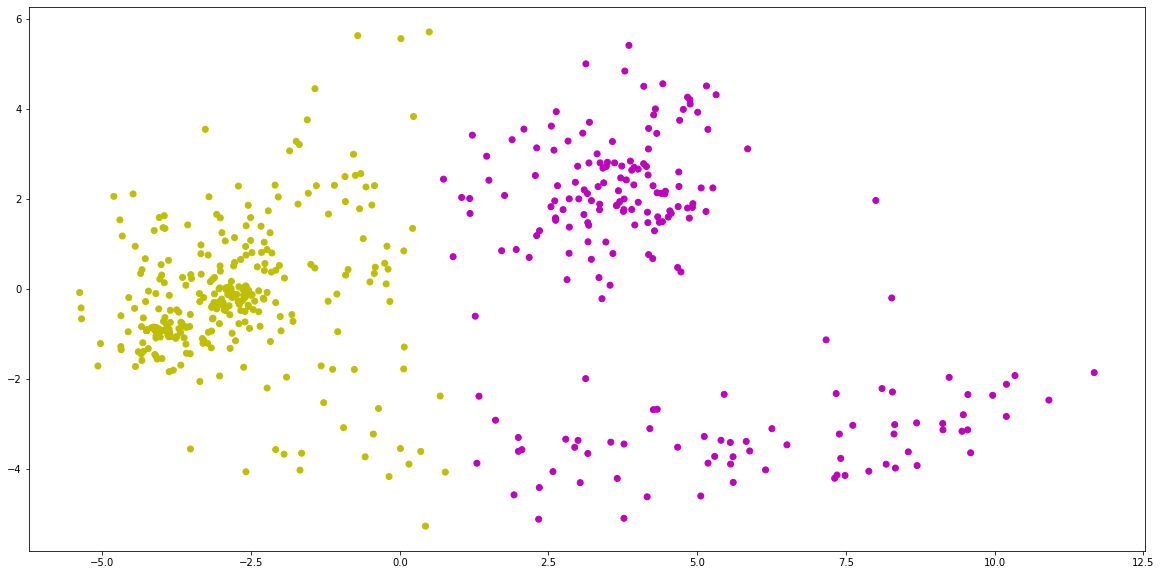

In [153]:
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(first)
colors = ["y", "m" ]

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]
fig, ax = plt.subplots(figsize=(20,10))

ax.scatter(x_axis, y_axis, c=[colors[d] for d in kmean_indices])